# MoGP Reference Model: Figure 4
This notebook includes analysis for comparing the performance of a reference model (trained on PROACT data) with that of study-specific models (trained on remaining external datasets)

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
from mogp import utils
from analysis_utils import *

import joblib
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu

In [3]:
# Formatting params
sns.set(font_scale=2, style="white", color_codes=False)

col_palette = ['#176D9C', '#DBA137','#86AF49' ,'#df473c','#ae3c60', '#82b4bb']

parameters_plot_4b = {'font.size':40,
              'axes.labelsize': 30,
              'axes.titlesize':40,
              'xtick.labelsize':30,
              'ytick.labelsize':30,
             'legend.fontsize':30,
             'figure.subplot.hspace':0.05,
             'figure.subplot.wspace':0.05, 
            'legend.frameon':False,
            'pdf.fonttype':42}

parameters_plot_4a = {'font.size':40,
              'axes.labelsize': 50,
              'axes.titlesize':40,
              'xtick.labelsize':35,
              'ytick.labelsize':35,
             'legend.fontsize':40,}

rename_labels = {'aals':'AALS', 'ceft': 'CEFT', 'proact':'PRO-ACT', 'emory':'EMORY', 
                 'reference_test_baseline': 'Baseline Error (PRO-ACT)', 
                 'proact_random_cluster': 'Random Cluster Assignment (PRO-ACT)'}
rename_cat_labels = {'reference_test': 'Reference Model (PRO-ACT)', 'studymod_test': 'Study-Specific Model'}

In [4]:
def gen_df_err_extend(cur_data, cur_mod, random_assignment=False, rand_seed=0):
    """Calculate error between patient real data and trajectory mean function of predicted cluster"""
    if random_assignment:
        np.random.seed(rand_seed)
        clust_list = (cur_mod.z).copy()
        np.random.permutation(clust_list)  
    
    df_err_extend = pd.DataFrame(columns=['full_id', 'id', 'proj', 'idx', 'clust', 'err'])

    for i in range(0,len(cur_data['SI'])):
        cur_x = cur_data['XA'][i]
        cur_x = cur_x[~np.isnan(cur_x)]
        cur_y = cur_data['YA'][i]
        cur_y = cur_y[~np.isnan(cur_y)]
        full_cur_id = cur_data['SI'][i]
        cur_id = cur_data['SI'][i].split('_')[0]
        cur_proj = cur_data['SI'][i].split('_')[1]

        if random_assignment:
            clust_assign = clust_list[i]
        else:
            rank_clust, _ = utils.rank_cluster_prediction(cur_mod, cur_x, cur_y)
            clust_assign = rank_clust[0]
            
        y_pred_mean = calc_y_pred_model(cur_mod, cur_x, clust_assign)
        err = calc_error(cur_y, y_pred_mean)
        df_err_extend = df_err_extend.append({'full_id':full_cur_id, 'id':cur_id, 'proj':cur_proj, 'idx':i, 'clust':clust_assign, 'err': err}, ignore_index=True)
    
    return df_err_extend

In [5]:
def calc_error_across_split(split, exp_path, exp_name, ext_projs, ref_proj):
    """Calculate error using reference model and study-specific models"""
    best_map_all = {}  #Store best MAP model
    ref_model = get_map_model(exp_path / 'results' / 'rbf', 'model_{}_{}_train_split_{}'.format('proact', exp_name, split)) # edit to include split
    
    best_map_all['proact'] = ref_model 
    df_err = pd.DataFrame()
    # External studies
    for proj in ext_projs:
        print('Calculate error for {}'.format(proj))
        cur_mod_name = 'model_{}_{}_train_split_{}'.format(proj, exp_name, split)
        ext_mod = get_map_model(exp_path / 'results' / 'rbf', cur_mod_name)
        best_map_all[proj] = ext_mod  #Store best MAP model
        
        # Study specific - Test data
        ext_test_data = joblib.load(exp_path / 'data_{}_{}_test_split_{}.pkl'.format(proj, exp_name, split))
        df_err_ext_controls = gen_df_err_extend(ext_test_data, ext_mod)
        df_err_ext_controls['cat']='studymod_test'
        df_err = df_err.append(df_err_ext_controls)

        # Reference Model - Test data
        df_err_ref = gen_df_err_extend(ext_test_data, ref_model)
        df_err_ref['cat']='reference_test'
        df_err = df_err.append(df_err_ref)
    
    # Reference Model
    print('Calculate error for reference model {}'.format(ref_proj))
    ref_train_data = joblib.load(exp_path / 'data_{}_{}_train_split_{}.pkl'.format(ref_proj, exp_name, split))
    ref_test_data = joblib.load(exp_path / 'data_{}_{}_test_split_{}.pkl'.format(ref_proj, exp_name, split))

    # PROACT Reference Model - Test data
    df_err_ref_proact = gen_df_err_extend(ref_test_data, ref_model)
    df_err_ref_proact['proj']='reference_test_baseline'
    df_err_ref_proact['cat']='reference_test'
    df_err = df_err.append(df_err_ref_proact)

    # PROACT Ref Model - Random Cluster
    df_err_extend_test_random = gen_df_err_extend(ref_test_data, ref_model, random_assignment=True, rand_seed=split) 
    df_err_extend_test_random['proj']='{}_random_cluster'.format(ref_proj)
    df_err_extend_test_random['cat']='reference_test'
    df_err = df_err.append(df_err_extend_test_random)
    
    df_err['split']=split
    return df_err, best_map_all

In [6]:
def calc_mwu_proj(comp, df):
    ref_err = df[(df['proj']==comp)&(df['cat']=='reference_test')]['err']
    study_err = df[(df['proj']==comp)&(df['cat']=='studymod_test')]['err']
    comp_stat, comp_pval = mannwhitneyu(ref_err, study_err, alternative='two-sided')
    return(comp_stat, comp_pval)

def conv_stats_asterix(pval, pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.1, "*"], [1, "ns"]]):
    for thresh in pvalue_thresholds:
        if pval <= thresh[0]:
            return thresh[1]
        
def plot_sidewise_err(ax, statdf, cur_patch):
    proj_patch = ax.get_yticklabels()[cur_patch].get_text()
    num_groups = len(ax.patches)/2
    x1 = ax.patches[cur_patch].get_y()+ax.patches[cur_patch].get_height()/2
    x2 = x1 + ax.patches[cur_patch].get_height()
    y2 = ax.patches[int(cur_patch+num_groups)].get_width()+0.5
    y1 = y2-0.15
    ax.plot([y1, y2, y2, y1], [x1, x1, x2, x2], linewidth=2.5, color=".2")
    
    asx_annot = conv_stats_asterix(statdf.loc[proj_patch]['proj_p'])
    ax.annotate(asx_annot, [y2+0.1, x1 + (x2-x1)/2 + 0.3])
    
    return ax

## Figure 4B: Error between reference and study-specific models

In [7]:
experiment_path = Path('data/model_data/3_reference_transfer')
experiment_name = 'min3_alsfrst'

external_projects = ['aals', 'emory', 'ceft']

reference_project = 'proact'

In [8]:
num_splits = 5

df_err_splits = pd.DataFrame()
map_model_splits = {}

for cur_split in range(0, num_splits):
    print('Currently: Split {}'.format(cur_split))
    df_err_extend_merge, map_model_dict = calc_error_across_split(split=cur_split, exp_path=experiment_path, exp_name=experiment_name, 
                                                  ext_projs=external_projects, ref_proj=reference_project)
    df_err_splits = df_err_splits.append(df_err_extend_merge)
    map_model_splits[cur_split]=map_model_dict

Currently: Split 0
seed did not pass monotonicity test: 4
best seed: 0, ll -2709.089380218339
Calculate error for aals
seed did not pass monotonicity test: 1
seed did not pass monotonicity test: 3
best seed: 2, ll -784.6451879719427
Calculate error for emory
seed did not pass monotonicity test: 1
seed did not pass monotonicity test: 2
seed did not pass monotonicity test: 4
best seed: 3, ll -820.6578348148815
Calculate error for ceft
seed did not pass monotonicity test: 2
best seed: 0, ll -761.7394841831659
Calculate error for reference model proact
Currently: Split 1
seed did not pass monotonicity test: 2
seed did not pass monotonicity test: 3
seed did not pass monotonicity test: 4
best seed: 1, ll -2657.36377383908
Calculate error for aals
seed did not pass monotonicity test: 4
best seed: 0, ll -832.4855928840482
Calculate error for emory
seed did not pass monotonicity test: 0
best seed: 3, ll -711.9931540993243
Calculate error for ceft
seed did not pass monotonicity test: 3
best seed

In [9]:
df_err_splits_summary = df_err_splits.groupby(['proj', 'cat', 'split']).mean().reset_index()

In [11]:
df_err_splits_summary.to_csv('reports/ref_mod_err_split_summ.csv', index=False)
# df_err_splits_summary = pd.read_csv('reports/ref_mod_err_split_summ.csv')

In [12]:
df_err_splits_summary.groupby(['proj', 'cat']).mean().round(2)

split    err
proj                    cat                         
aals                    reference_test      2   2.16
                        studymod_test       2   2.75
ceft                    reference_test      2   2.25
                        studymod_test       2   2.85
emory                   reference_test      2   2.32
                        studymod_test       2   3.09
proact_random_cluster   reference_test      2  11.74
reference_test_baseline reference_test      2   1.88

In [13]:
plt.rcParams.update(parameters_plot_4b)

aals (refmodel vs studymodel), p-val:0.012185780355344813, U_stat:0.0
emory (refmodel vs studymodel), p-val:0.012185780355344813, U_stat:0.0
ceft (refmodel vs studymodel), p-val:0.012185780355344813, U_stat:0.0


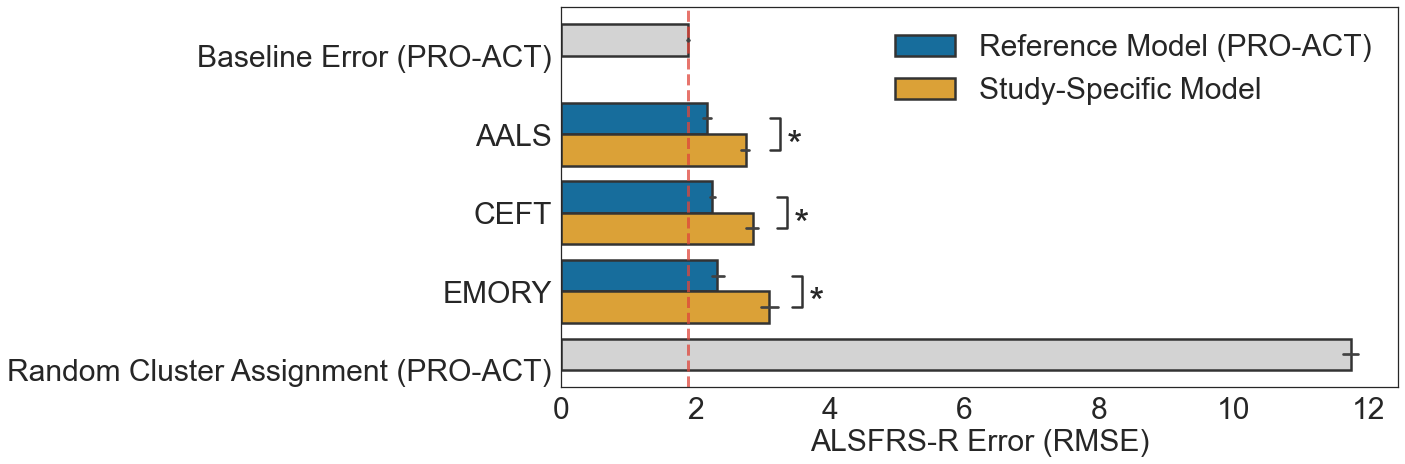

In [14]:
# Plot Figure
fig, ax = plt.subplots(1,1, figsize = (15,7))
df_err_extend_relabel = df_err_splits_summary.replace({'proj':rename_labels, 'cat':rename_cat_labels})

mean_proj = df_err_extend_relabel.groupby('proj').mean()
order = mean_proj.sort_values('err').index
hue_order = [rename_cat_labels['reference_test'], rename_cat_labels['studymod_test']]

ax = sns.barplot(x='err', y='proj', hue='cat', data=df_err_extend_relabel, ax=ax, order=order, 
            hue_order=hue_order, saturation=1, edgecolor=".2", linewidth=2.5, palette=col_palette)

_ = ax.axvline(mean_proj.loc[rename_labels['reference_test_baseline']]['err'], color=col_palette[3], 
           linewidth=3, linestyle='dashed', alpha=0.75)

_ = ax.set(xlabel='ALSFRS-R Error (RMSE)', ylabel='');
_ = ax.legend(loc='upper right')

#Calculate statistics
df_stats = pd.DataFrame()
for cur_proj in external_projects:
    proj_stat, proj_p = calc_mwu_proj(cur_proj, df_err_splits_summary)
    df_stats = df_stats.append({'proj':cur_proj, 'proj_stat':proj_stat, 'proj_p':proj_p}, ignore_index=True)
    print('{} (refmodel vs studymodel), p-val:{}, U_stat:{}'.format(cur_proj, proj_p, proj_stat))
    
df_stats_relabel = df_stats.replace({'proj':rename_labels}).set_index('proj')

#Format bar plot locations
last_ext_proj = len(external_projects)+1

ax.patches[0].set_facecolor('lightgray')
ax.patches[last_ext_proj].set_facecolor('lightgray')

for grp in range(1,last_ext_proj):
    ax = plot_sidewise_err(ax, df_stats_relabel, grp)

# Save Figure
fig.savefig('reports/fig_reference_model_barplots.pdf', bbox_inches='tight');

In [15]:
# # Confirm w statsmodel: Stats test: 
# mod_list = ['reference_test', 'studymod_test']
# box_pairs = [((rename_labels[x],rename_cat_labels[mod_list[0]]), (rename_labels[x],rename_cat_labels[mod_list[1]])) for x in external_projects]


# box_pairs
# _ = add_stat_annotation(ax, x='err', y='proj', hue='cat', data=df_err_extend_relabel,
#                                        box_pairs=box_pairs, 
#                                        test='Mann-Whitney', text_format='star', #two-sided MWU
#                                        loc='outside', verbose=2, comparisons_correction=None)

## Figure 4A: Visualzing trajectory predictions

In [16]:
plt.rcParams.update(parameters_plot_4a)

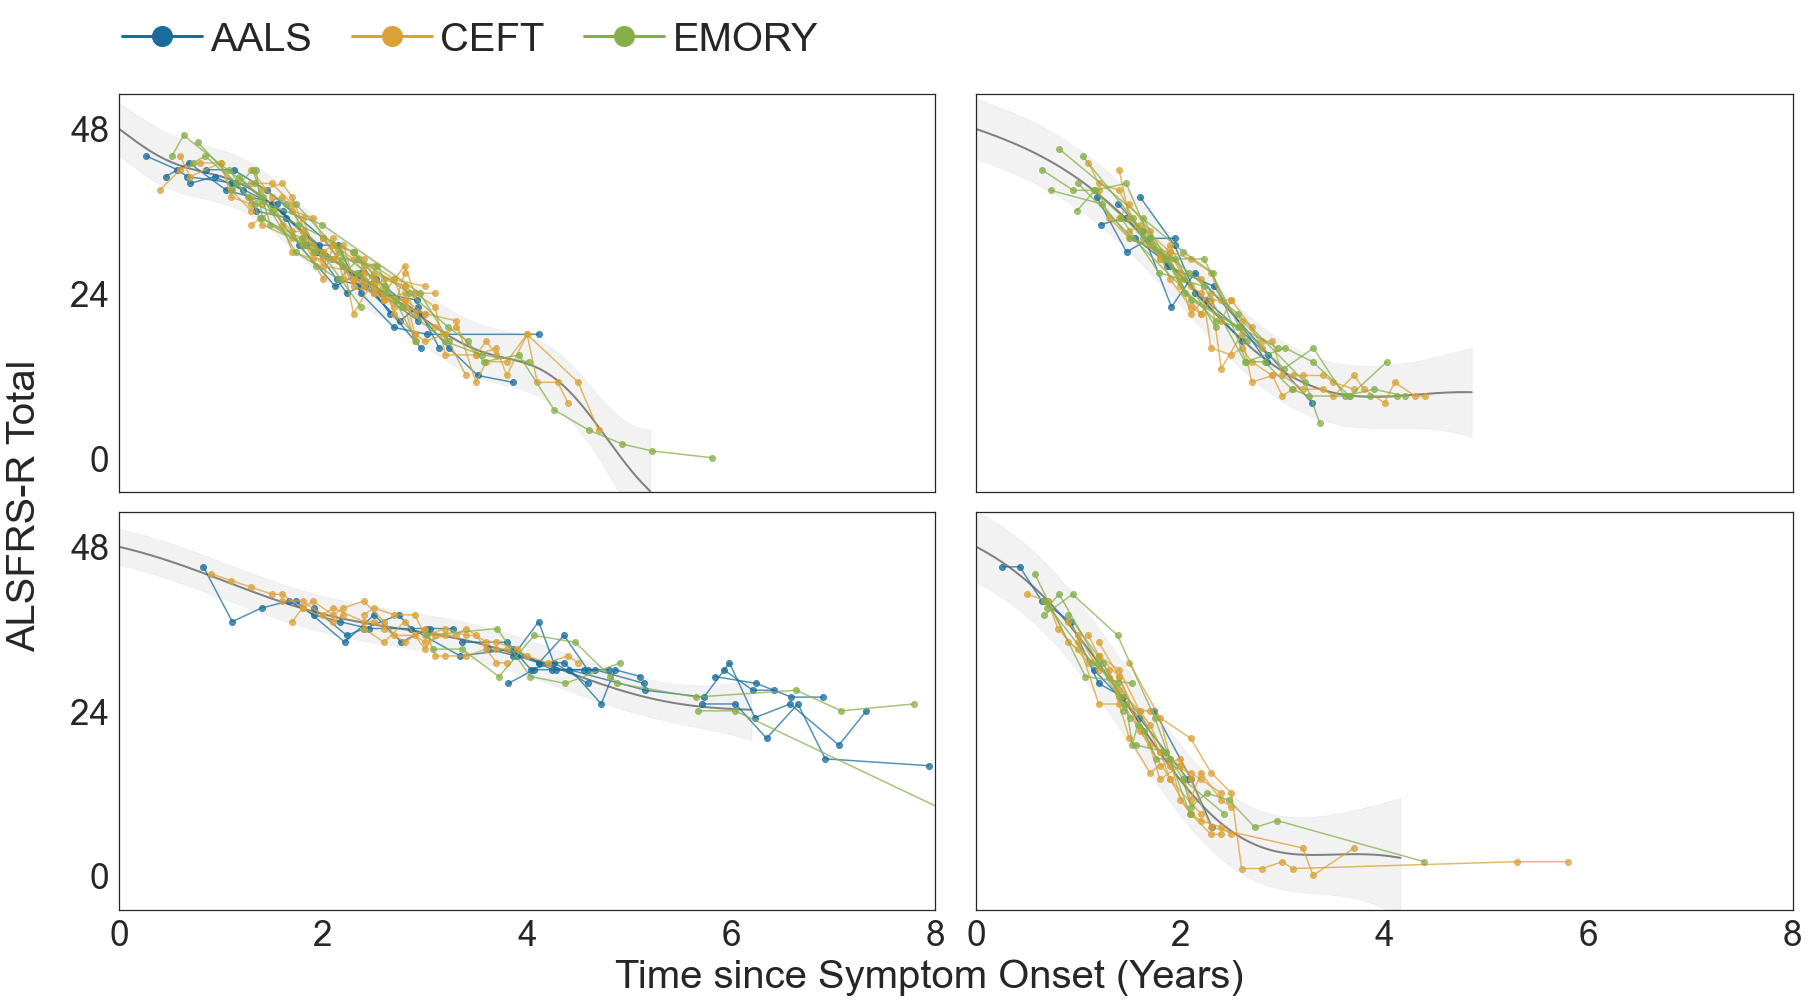

In [17]:
# Select representative split for figure
cur_split = 1

# Replace with path to full proact model
reference_model = map_model_splits[cur_split]['proact']

# Load data
proj_list = ['aals', 'ceft', 'emory']

proj_data_dict = {}
for cur_proj in proj_list:
    proj_data_dict[cur_proj]=joblib.load(experiment_path / 'data_{}_{}_test_split_{}.pkl'.format(cur_proj, experiment_name, cur_split))

df_err_curr = df_err_splits[(df_err_splits['cat']=='reference_test')&(df_err_splits['proj'].isin(proj_list)) & (df_err_splits['split']==cur_split)]

# Plot Figure
fig, axs = plt.subplots(2, 2, figsize=(30,15), sharex=True, sharey=True)
dist_clust = 4
proj_dict = dict(zip(proj_list, col_palette))

k_lis = df_err_curr['clust'].value_counts()[0:dist_clust].index
for k_i, k in enumerate(k_lis):
    ax = axs.flat[k_i]
    ax, _ = plot_mogp_by_clust(ax=ax, model=reference_model, data=None, k=k, data_flag=False, model_col='gray', model_alpha=0.1)
    for proj in proj_list:
        # Plot data
        proj_idx_k = list(df_err_curr[(df_err_curr['proj']==proj) & (df_err_curr['clust']==k)]['idx'])
        proj_data = proj_data_dict[proj]
        x = proj_data['XA']
        y = proj_data['YA']
        _ = ax.plot(x[proj_idx_k].T[1:], y[proj_idx_k].T[1:], 'o-', color=proj_dict[proj], alpha=0.75)
        ax = format_mogp_axs(ax)
    ax.get_legend().remove()
    
_ = fig.text(0.5, 0.08, 'Time since Symptom Onset (Years)', va='top', ha='center', transform=fig.transFigure)
_ = fig.text(0.09, 0.5, 'ALSFRS-R Total', rotation='vertical', va='center', ha='right', transform=fig.transFigure)
_ = axs.flat[0].legend(
    handles=[matplotlib.lines.Line2D([], [], color=proj_dict[p], marker='o', linewidth=3, markersize=20, label=rename_labels[p]) for p in proj_dict.keys()],
    ncol=5, frameon=False, loc='lower left', bbox_to_anchor=(-0.04,1), handletextpad=0.2, columnspacing=1)

# # Save Figure
fig.savefig('reports/fig_reference_model_trajplots.pdf', bbox_inches='tight');